In [1]:
from google.colab import drive
drive.mount('/content/drive')


%cd '/content/drive/My Drive/tfg/tfg/'

# Mostrar el directorio actual para confirmar el cambio
directorio_actual = %pwd
print("Directorio actual:", directorio_actual)

Mounted at /content/drive
/content/drive/.shortcut-targets-by-id/10WLcTPxhJDTxR9pv6DkdJbsqxpkkFOIV/tfg/tfg
Directorio actual: /content/drive/.shortcut-targets-by-id/10WLcTPxhJDTxR9pv6DkdJbsqxpkkFOIV/tfg/tfg


In [2]:
import os
import pandas as pd
path_actual = os.getcwd()
subdirectorio = 'datas'
file_train = 'df_train.csv'
path_train = os.path.join(path_actual, subdirectorio, file_train)

In [3]:
file_valid = 'df_valid.csv'
path_valid = os.path.join(path_actual, subdirectorio, file_valid)

In [4]:
import pandas as pd

df_train = pd.read_csv(path_train, index_col=None)
df_valid = pd.read_csv(path_valid, index_col=None)

In [5]:
import numpy as np
import pandas as pd

def filtrado_datos_variable(df):
    kaones = []
    labels = []

    df_sorted = df.sort_values(by=['eventID', 'hitTime'], ascending=[True, False])

    for eventID, grupo in df_sorted.groupby('eventID'):
        pdgCodes = grupo['PDGcode'].unique()

        for pdgCode in pdgCodes:
            grupo_filtrado = grupo[grupo['PDGcode'] == pdgCode]

            # Extraer directamente los valores
            hitX_values = grupo_filtrado['hitX'].values
            hitY_values = grupo_filtrado['hitY'].values
            hitZ_values = grupo_filtrado['hitZ'].values
            hitInteg_values = grupo_filtrado['hitInteg'].values

            # Concatenar los valores directamente sin padding
            hit_values_reorganized = np.concatenate([hitX_values, hitY_values, hitZ_values, hitInteg_values])

            kaones.append(hit_values_reorganized)

            # Modificar las etiquetas de 211 a 0 y de 321 a 1
            if pdgCode == 211:
                labels.append(0)
            elif pdgCode == 321:
                labels.append(1)

    return kaones, np.array(labels)


In [6]:
df_train = pd.read_csv(path_train, index_col=None)
df_valid = pd.read_csv(path_valid, index_col=None)

In [7]:
X_train, y_train = filtrado_datos_variable(df_train)
X_valid, y_valid = filtrado_datos_variable(df_valid)

In [8]:
tam = np.array([])
for fila in X_train:
  tam = np.append(tam, len(fila))


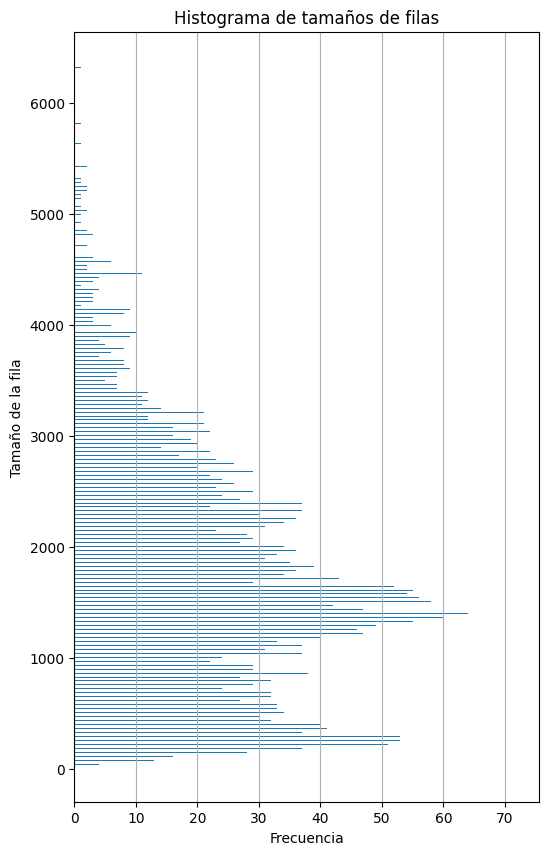

In [ ]:
import matplotlib.pyplot as plt

# Calcular los tamaños de las filas
tam = np.array([len(fila) for fila in X_train])

# Crear el histograma vertical
plt.figure(figsize=(6,10))
plt.hist(tam, bins=range(min(tam), max(tam) + 1), orientation='horizontal')
plt.xlabel('Frecuencia')
plt.ylabel('Tamaño de la fila')
plt.title('Histograma de tamaños de filas')
plt.grid(axis='x')
plt.show()

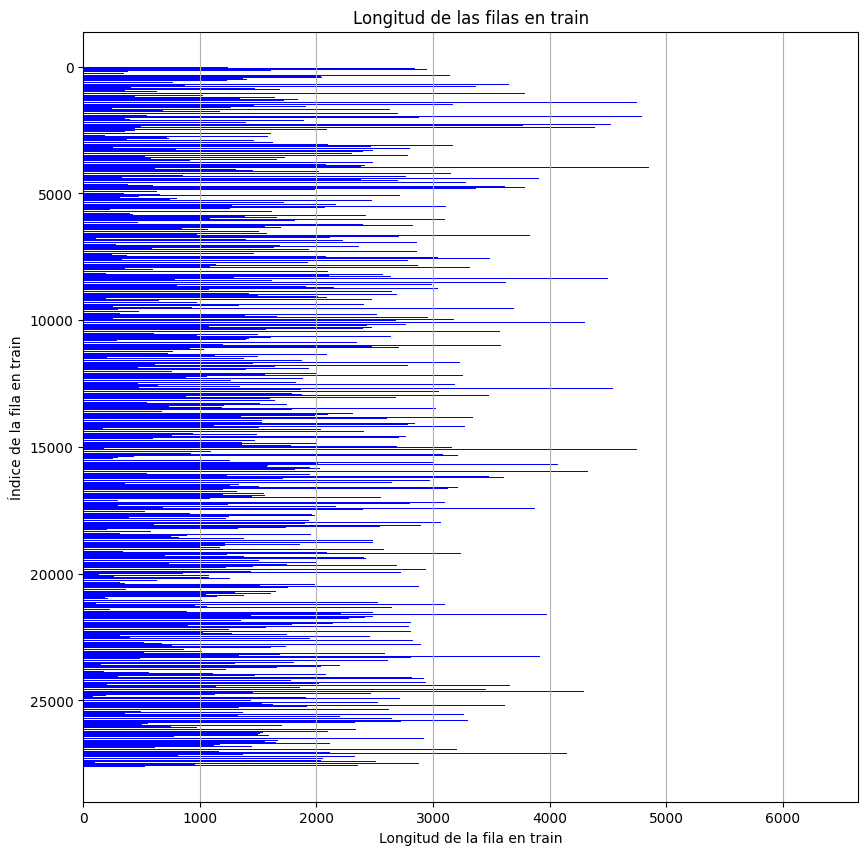

In [ ]:
plt.figure(figsize=(10,10))
plt.barh(range(len(tam)), tam, color='b')
plt.ylabel('Índice de la fila en train')
plt.xlabel('Longitud de la fila en train')
plt.title('Longitud de las filas en train')
plt.gca().invert_yaxis()  # Invertir el eje y para que las filas aparezcan en el orden correcto
plt.grid(axis='x')
plt.show()

In [9]:
from keras.preprocessing.sequence import pad_sequences

max_length = max(len(seq) for seq in X_train)
X_train_p = pad_sequences(X_train, maxlen=max_length, padding='post', dtype='float32')
X_train_p = np.expand_dims(X_train_p, -1)


In [13]:
### Calcular el porcentaje de padding

total_elementos = np.prod(X_train_p.shape)

non_padding_elementos = sum(len(seq) for seq in X_train)

padding_elementos = total_elementos - non_padding_elementos

padding_porcentaje = (padding_elementos / total_elementos) * 100

print(f"El porcentaje de padding es: {padding_porcentaje:.2f}%")




El porcentaje de padding es: 73.42%


In [10]:
X_valid_p = pad_sequences(X_valid, maxlen=max_length, padding='post', dtype='float32')
X_valid_p = np.expand_dims(X_valid_p, -1)


In [ ]:
from keras.models import Sequential
from keras.layers import Conv1D, GlobalAveragePooling1D, Dense, BatchNormalization, Dropout
from keras.regularizers import l1_l2
from keras.optimizers import Adam
from tensorflow.keras.layers import Masking

# Funcion para crear el modelo
def create_model_CNN(input_shape):
    model = Sequential()

    # Capa de máscara para ignorar los valores de padding
    model.add(Masking(mask_value=0.0, input_shape=input_shape))

    # Se eliminan las especificaciones de input_shape para permitir cualquier longitud de entrada
    model.add(Conv1D(filters=128, kernel_size=10, padding='valid', activation='relu'))
    model.add(Conv1D(filters=256, kernel_size=8, padding='valid', activation='relu'))
    model.add(GlobalAveragePooling1D())  # Usar Global Average Pooling
    model.add(Dense(256, activation='relu'))
    model.add(Dense(128, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(optimizer=Adam(lr=0.001), loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Asumiendo que X_train y X_valid ya están disponibles como listas de arrays de numpy con dimensiones (samples, features)
# No es necesario reorganizar los datos ya que no especificamos una longitud fija

# Creamos el modelo
model_CNN = create_model_CNN(input_shape=X_train_p.shape[1:])

# Definimos callbacks para los entrenamientos
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
early_stop = EarlyStopping(monitor='val_loss', patience=2, verbose=1, mode='min', restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=0, min_lr=0.00001)

# Entrenamos el modelo
history_CNN = model_CNN.fit(X_train_p, y_train, epochs=50, batch_size=32, validation_data=(X_valid_p, y_valid), callbacks=[early_stop, reduce_lr])

# Evaluamos el modelo
loss, accuracy = model_CNN.evaluate(X_valid_p, y_valid)
print("Loss:", loss)
print("Accuracy:", accuracy)


Epoch 1/50
863/863 [==============================] - 85s 90ms/step - loss: 0.5061 - accuracy: 0.7728 - val_loss: 0.4928 - val_accuracy: 0.7742 - lr: 0.0010
Epoch 2/50
863/863 [==============================] - 75s 87ms/step - loss: 0.3939 - accuracy: 0.8180 - val_loss: 0.3872 - val_accuracy: 0.8282 - lr: 0.0010
Epoch 3/50
863/863 [==============================] - 79s 91ms/step - loss: 0.3343 - accuracy: 0.8616 - val_loss: 0.3320 - val_accuracy: 0.8605 - lr: 0.0010
Epoch 4/50
863/863 [==============================] - 74s 86ms/step - loss: 0.3041 - accuracy: 0.8792 - val_loss: 0.2954 - val_accuracy: 0.8843 - lr: 0.0010
Epoch 5/50
863/863 [==============================] - 78s 91ms/step - loss: 0.2857 - accuracy: 0.8860 - val_loss: 0.2879 - val_accuracy: 0.8837 - lr: 0.0010
Epoch 6/50
863/863 [==============================] - 79s 91ms/step - loss: 0.2606 - accuracy: 0.8972 - val_loss: 0.2502 - val_accuracy: 0.8986 - lr: 0.0010
Epoch 7/50
863/863 [==============================] - 78s 

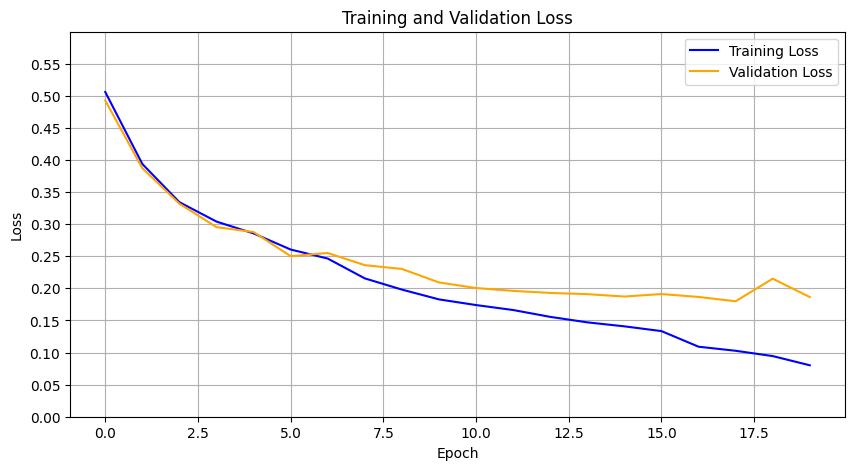

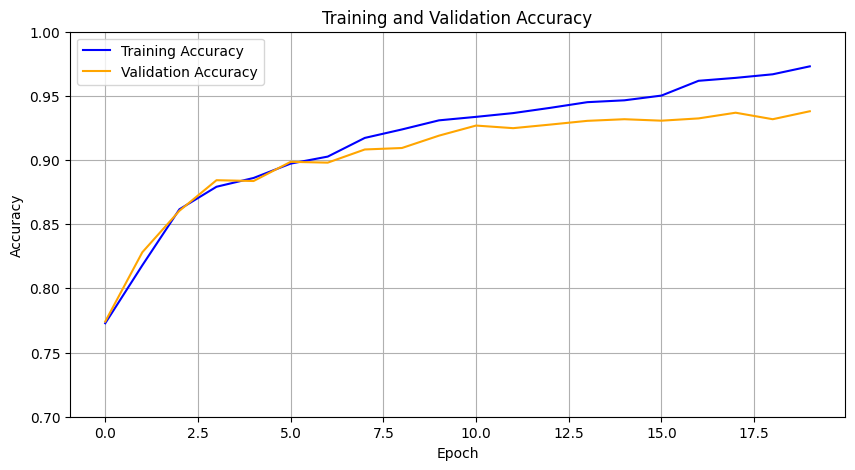

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

history =history_CNN.history

plt.figure(figsize=(10, 5))
plt.plot(history['loss'], label='Training Loss', color='blue')
plt.plot(history['val_loss'], label='Validation Loss', color='orange')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
min_y=0
max_y=0.6
plt.ylim(min_y, max_y)
plt.yticks(np.arange(min_y, max_y, 0.05))
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(history['accuracy'], label='Training Accuracy', color='blue')
plt.plot(history['val_accuracy'], label='Validation Accuracy', color='orange')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
min_y=0.7
max_y=1
plt.ylim(min_y, max_y)
plt.yticks(np.arange(min_y, max_y, 0.05))
plt.show()

In [ ]:
del model_CNN

In [15]:
from keras.models import Sequential
from keras.layers import Masking, LSTM, Dense, GlobalAveragePooling1D
from keras.optimizers import Adam
from keras.regularizers import l1_l2
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

def create_model_LSTM(input_shape):
    model = Sequential()

    # Capa de máscara para ignorar los valores de padding
    model.add(Masking(mask_value=0.0, input_shape=input_shape))

    # Capa LSTM
    model.add(LSTM(128, return_sequences=True))

    # Global Average Pooling
    model.add(GlobalAveragePooling1D())

    # Capas densas
    model.add(Dense(256, activation='relu'))
    model.add(Dense(128, activation='relu'))

    # Capa de salida
    model.add(Dense(1, activation='sigmoid'))

    # Compilar el modelo
    model.compile(optimizer=Adam(lr=0.001), loss='binary_crossentropy', metrics=['accuracy'])
    return model


# Creamos el modelo
model_LSTM = create_model_LSTM(input_shape=X_train_p.shape[1:])


early_stop = EarlyStopping(monitor='val_loss', patience=2, verbose=1, mode='min', restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=0, min_lr=0.00001)

# Entrenamos el modelo
history_LSTM = model_LSTM.fit(X_train_p, y_train, epochs=50, batch_size=32, validation_data=(X_valid_p, y_valid), callbacks=[early_stop, reduce_lr])

# Evaluamos el modelo
loss, accuracy = model_LSTM.evaluate(X_valid_p, y_valid)
print("Loss:", loss)
print("Accuracy:", accuracy)

Epoch 1/50
 15/863 [..............................] - ETA: 2:52:45 - loss: 0.6125 - accuracy: 0.6521

KeyboardInterrupt: 

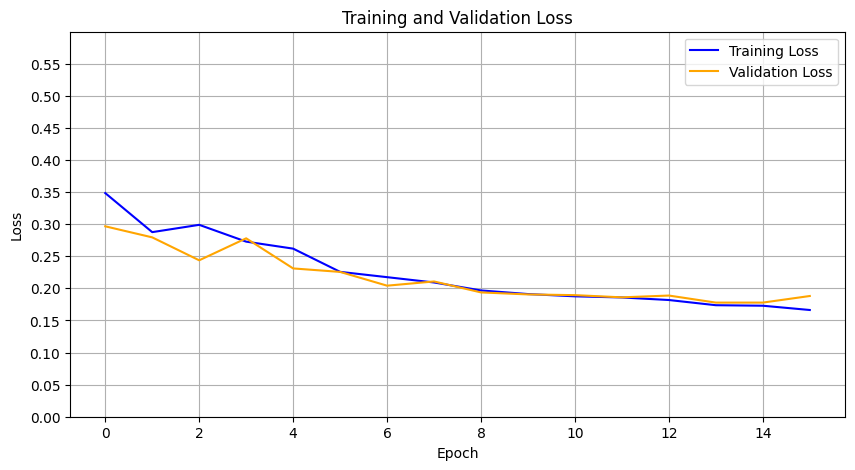

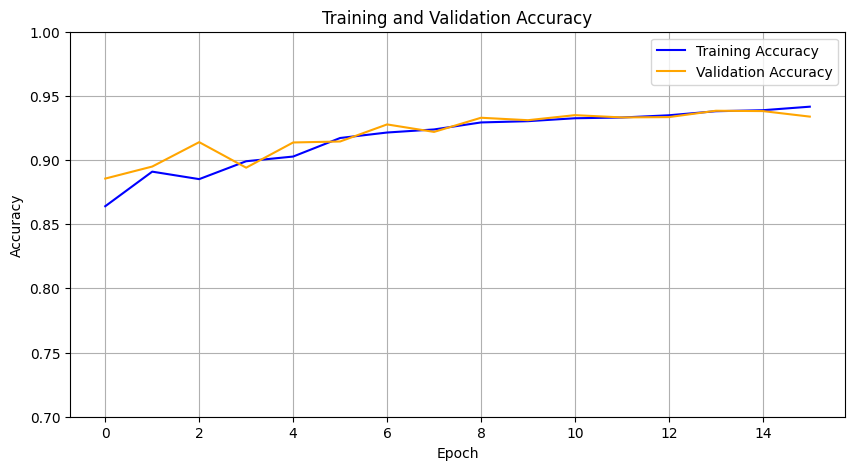

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

history =history_LSTM.history

plt.figure(figsize=(10, 5))
plt.plot(history['loss'], label='Training Loss', color='blue')
plt.plot(history['val_loss'], label='Validation Loss', color='orange')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
min_y=0
max_y=0.6
plt.ylim(min_y, max_y)
plt.yticks(np.arange(min_y, max_y, 0.05))
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(history['accuracy'], label='Training Accuracy', color='blue')
plt.plot(history['val_accuracy'], label='Validation Accuracy', color='orange')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
min_y=0.7
max_y=1
plt.ylim(min_y, max_y)
plt.yticks(np.arange(min_y, max_y, 0.05))
plt.show()

In [12]:
from keras.models import Sequential
from keras.layers import Masking, GRU, Dense, GlobalAveragePooling1D
from keras.optimizers import Adam
from keras.regularizers import l1_l2
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

def create_model_GRU(input_shape):
    model = Sequential()

    # Capa de máscara para ignorar los valores de padding
    # model.add(Masking(mask_value=0.0, input_shape=input_shape))

    # Capa GRU
    model.add(GRU(128, return_sequences=True))

    # Global Average Pooling
    model.add(GlobalAveragePooling1D())

    # Capas densas
    model.add(Dense(256, activation='relu', kernel_regularizer=l1_l2(l1=0.001, l2=0.001)))
    model.add(Dense(128, activation='relu', kernel_regularizer=l1_l2(l1=0.001, l2=0.001)))

    # Capa de salida
    model.add(Dense(1, activation='sigmoid'))

    # Compilar el modelo
    model.compile(optimizer=Adam(lr=0.001), loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Creamos el modelo
model_GRU = create_model_GRU(input_shape=X_train_p.shape[1:])


early_stop = EarlyStopping(monitor='val_loss', patience=2, verbose=1, mode='min', restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=0, min_lr=0.00001)

# Entrenamos el modelo
history_GRU = model_GRU.fit(X_train_p, y_train, epochs=50, batch_size=32, validation_data=(X_valid_p, y_valid), callbacks=[early_stop, reduce_lr])

# Evaluamos el modelo
loss, accuracy = model_GRU.evaluate(X_valid_p, y_valid)
print("Loss:", loss)
print("Accuracy:", accuracy)

Epoch 1/50
863/863 [==============================] - 177s 198ms/step - loss: 0.7022 - accuracy: 0.8651 - val_loss: 0.3684 - val_accuracy: 0.9000 - lr: 0.0010
Epoch 2/50
863/863 [==============================] - 173s 200ms/step - loss: 0.3547 - accuracy: 0.8962 - val_loss: 0.3248 - val_accuracy: 0.9090 - lr: 0.0010
Epoch 3/50
863/863 [==============================] - 173s 200ms/step - loss: 0.3159 - accuracy: 0.9059 - val_loss: 0.2989 - val_accuracy: 0.9102 - lr: 0.0010
Epoch 4/50
863/863 [==============================] - 174s 201ms/step - loss: 0.2933 - accuracy: 0.9123 - val_loss: 0.2833 - val_accuracy: 0.9145 - lr: 0.0010
Epoch 5/50
863/863 [==============================] - 173s 200ms/step - loss: 0.3031 - accuracy: 0.9105 - val_loss: 0.2868 - val_accuracy: 0.9178 - lr: 0.0010
Epoch 6/50
863/863 [==============================] - 173s 200ms/step - loss: 0.2782 - accuracy: 0.9181 - val_loss: 0.2725 - val_accuracy: 0.9219 - lr: 5.0000e-04
Epoch 7/50
863/863 [======================

KeyboardInterrupt: 

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

history =history_GRU.history

plt.figure(figsize=(10, 5))
plt.plot(history['loss'], label='Training Loss', color='blue')
plt.plot(history['val_loss'], label='Validation Loss', color='orange')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
min_y=0
max_y=0.6
plt.ylim(min_y, max_y)
plt.yticks(np.arange(min_y, max_y, 0.05))
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(history['accuracy'], label='Training Accuracy', color='blue')
plt.plot(history['val_accuracy'], label='Validation Accuracy', color='orange')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
min_y=0.7
max_y=1
plt.ylim(min_y, max_y)
plt.yticks(np.arange(min_y, max_y, 0.05))
plt.show()

### Comparativa de los 3 modelos

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

history_LSTM =history_LSTM.history
history_GRU = history_GRU.history
history_CNN = history_CNN.history

plt.figure(figsize=(10, 5))
plt.plot(history_LSTM['loss'], label='Training Loss LSTM')
plt.plot(history_GRU['loss'], label='Training Loss GRU')
plt.plot(history_CNN['loss'], label='Training Loss CNN')
plt.title('Comparativa Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
min_y=0
max_y=0.6
plt.ylim(min_y, max_y)
plt.yticks(np.arange(min_y, max_y, 0.05))
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(history_LSTM['val_loss'], label='Validation Loss LSTM')
plt.plot(history_GRU['val_loss'], label='Validation Loss GRU')
plt.plot(history_CNN['val_loss'], label='Validation Loss CNN')
plt.title('Comparativa Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
min_y=0
max_y=0.6
plt.ylim(min_y, max_y)
plt.yticks(np.arange(min_y, max_y, 0.05))
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(history_LSTM['accuracy'], label='Training Accuracy LSTM')
plt.plot(history_GRU['accuracy'], label='Training Accuracy GRU')
plt.plot(history_CNN['accuracy'], label='Training Accuracy CNN')
plt.title('Comparativa Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
min_y=0.7
max_y=1
plt.ylim(min_y, max_y)
plt.yticks(np.arange(min_y, max_y, 0.05))
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(history_LSTM['val_accuracy'], label='Validation Accuracy LSTM')
plt.plot(history_GRU['val_accuracy'], label='Validation Accuracy GRU')
plt.plot(history_CNN['val_accuracy'], label='Validation Accuracy CNN')
plt.title('Comparativa Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
min_y=0.7
max_y=1
plt.ylim(min_y, max_y)
plt.yticks(np.arange(min_y, max_y, 0.05))
plt.show()


Segun estas gráficas el mejor modelo es _____.

### El mejor modelo lo entreno con CV
https://github.com/christianversloot/machine-learning-articles/blob/main/how-to-use-k-fold-cross-validation-with-keras.md

Unimos los datos de validacion y train para entrenar con CV

In [ ]:
def create_model_LSTM(input_shape):
    model = Sequential()

    # Capa de máscara para ignorar los valores de padding
    # model.add(Masking(mask_value=0.0, input_shape=input_shape))

    # Capa LSTM
    model.add(LSTM(128, return_sequences=True))

    # Global Average Pooling
    model.add(GlobalAveragePooling1D())

    # Capas densas
    model.add(Dense(256, activation='relu'))
    model.add(Dense(128, activation='relu'))

    # Capa de salida
    model.add(Dense(1, activation='sigmoid'))

    # Compilar el modelo
    model.compile(optimizer=Adam(lr=0.001), loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [ ]:
print('Dimensiones de df_train:', df_train.shape)
print('Dimensiones de df_valid:', df_valid.shape)
df_combinado = pd.concat([df_train, df_valid])
print('Dimensiones combinado:', df_combinado.shape)

In [ ]:
X, y = filtrado_datos_variable(df_combinado)

max_length = max(len(seq) for seq in X)

X = pad_sequences(X, maxlen=max_length, padding='post', dtype='float32')
X = np.expand_dims(X, -1)


In [ ]:
from sklearn.model_selection import KFold
from keras.models import Sequential
from keras.layers import Masking, LSTM, Dense, GlobalAveragePooling1D
from keras.optimizers import Adam
from keras.regularizers import l1_l2
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

# KFold setup
kfold = KFold(n_splits=5, shuffle=True)
acc_per_fold = []
loss_per_fold = []
fold_no = 1

# Callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=2, verbose=1, mode='min', restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=0, min_lr=0.00001)

# K-fold Cross Validation model evaluation
for train, validation in kfold.split(X, y):
    print('------------------------------------------------------------------------')
    print(f'Training for fold {fold_no} ...')

    # Create a new instance of the model for each fold
    model = create_model_LSTM(input_shape=(X.shape[1], X.shape[2]))  # Make sure to adjust the input_shape to match your data

    # Training
    history = model.fit(X[train], y[train], batch_size=32, epochs=50,
                        validation_data=(X[validation], y[validation]),
                        callbacks=[early_stop, reduce_lr])

    # Evaluating the model
    scores = model.evaluate(X[validation], y[validation], verbose=0)
    print(f'Score for fold {fold_no}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]}')
    acc_per_fold.append(scores[1])
    loss_per_fold.append(scores[0])

    fold_no += 1

# Output the average scores after the cross-validation
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Accuracy: {np.mean(acc_per_fold):.4f} (+- {np.std(acc_per_fold):.4f})')
print(f'> Loss: {np.mean(loss_per_fold):.4f}')
print('------------------------------------------------------------------------')




In [ ]:
print(acc_per_fold)
print(loss_per_fold)

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(loss_per_fold, label='Loss LSTM CV')
plt.title('Comparativa CV Loss')
plt.xlabel('Fold')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
min_y=0
max_y=0.6
plt.ylim(min_y, max_y)
plt.yticks(np.arange(min_y, max_y, 0.05))
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(acc_per_fold, label='Accuracy LSTM CV')
plt.title('Comparativa CV Accuracy')
plt.xlabel('Fold')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
min_y=0.7
max_y=1
plt.ylim(min_y, max_y)
plt.yticks(np.arange(min_y, max_y, 0.05))
plt.show()